In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from joblib import Parallel, delayed


In [2]:
# Load the dataset
data = pd.read_csv("text.csv") 
X = data['text']
y = data['label']

In [4]:
def remove_outliers(text_data, min_len=5, max_len=280, alpha_ratio=0.5):
    """
    Removes outliers from the text data based on text length and character composition.
    """
    def is_outlier(text):
        if len(text) < min_len or len(text) > max_len:
            return True
        alpha_count = len(re.findall(r'[a-zA-Z]', text))
        return alpha_count / max(len(text), 1) < alpha_ratio

    # Parallel processing of outlier detection
    outliers = Parallel(n_jobs=-1)(delayed(is_outlier)(text) for text in text_data)
    return text_data[~pd.Series(outliers)]

# Parallel outlier removal
start_time = time.time()
filtered_text = remove_outliers(X)
filtered_data = data[data['text'].isin(filtered_text)].reset_index(drop=True)  
outlier_removal_time = time.time() - start_time

# Update X and y with filtered data
X_filtered = filtered_data['text']
y_filtered = filtered_data['label']

print(f"Outlier Removal Time (Parallel): {outlier_removal_time:.2f} seconds")

Outlier Removal Time (Parallel): 5.69 seconds


In [5]:
# Parallel Data Preprocessing using TF-IDF
def preprocess_data(text_data, max_features=1000):
    vectorizer = TfidfVectorizer(max_features=max_features)
    return vectorizer.fit_transform(text_data)

# Parallel Data Preprocessing
start_time = time.time()
X_vect = preprocess_data(X_filtered)
data_preprocessing_time = time.time() - start_time

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y_filtered, test_size=0.2, random_state=42)

print(f"Data Preprocessing Time (Parallel): {data_preprocessing_time:.2f} seconds")

Data Preprocessing Time (Parallel): 11.42 seconds


Logistic Regression Results:
Training Time: 15.13 seconds
Prediction Time: 0.04 seconds
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1 Score: 0.86



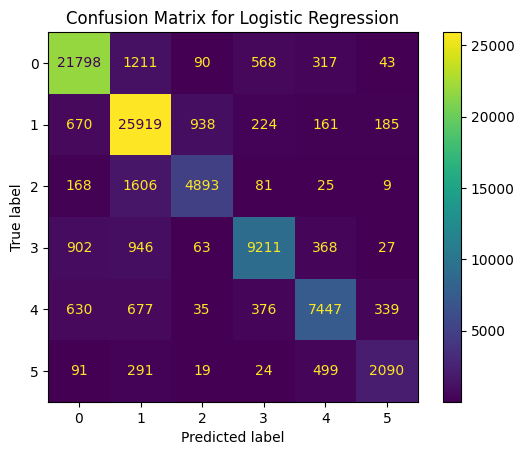

Naive Bayes Results:
Training Time: 0.14 seconds
Prediction Time: 0.02 seconds
Accuracy: 0.82
Precision: 0.84
Recall: 0.82
F1 Score: 0.81



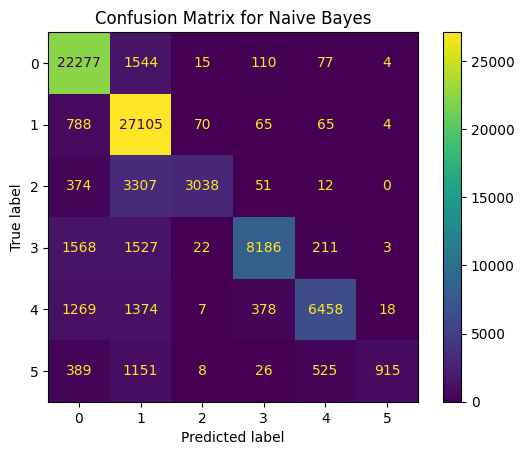

In [9]:
# Function to train a model and measure performance
def train_model(model_class, X_train, y_train):
    start_time = time.time()
    model = model_class()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    return model, training_time

# Function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name, training_time):
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print results
    print(f"{model_name} Results:")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Prediction Time: {prediction_time:.2f} seconds")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}\n")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='viridis')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

# Train and evaluate models in parallel
models = [LogisticRegression(max_iter=1000), MultinomialNB()]
model_names = ["Logistic Regression", "Naive Bayes"]

# Parallel model training and evaluation
results = Parallel(n_jobs=-1)(
    delayed(train_model)(model.__class__, X_train, y_train) for model in models
)

# Evaluate models
for (model, training_time), model_name in zip(results, model_names):
    evaluate_model(model, X_test, y_test, model_name, training_time)